Loading modules

In [1]:
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pytz
import calendar
import cartopy.crs as ccrs
import netCDF4 as nc
import pandas as pd
import matplotlib.dates as mdates
import glob
import requests
import io
import json
from os import path

Import dataset and reconstruct it to gridded dataset of time, lat, lon

In [2]:
nc2020 = nc.Dataset("gfed_data/GFED4.1s_2020_beta.hdf5")

In [3]:
nc2020.groups['emissions'].groups['01'].variables['C']

<class 'netCDF4._netCDF4.Variable'>
float32 C(phony_dim_8, phony_dim_9)
    long_name: GFED4s biomass burning carbon emissions
    units: g C / m^2 / month
path = /emissions/01
unlimited dimensions: 
current shape = (720, 1440)
filling off

In [4]:
lat_array = np.array(nc2020.variables['lat'])[:, 0]
lon_array = np.array(nc2020.variables['lon'])[0, :]
time_2020 = np.arange('2020-01-01', '2020-11-01', dtype='datetime64[D]')

Using daily fraction, split monthly emission into daily emission

In [5]:
year = 2020
C_2020 = None
for month in range(1, 11):
    nc_2020_mo = nc2020.groups['emissions'][str(month).zfill(2)]
    nc_2020_mo_C = np.array(nc_2020_mo.variables['C'])
    last_day = calendar.monthrange(year,month)[1]
    daily_fraction = np.empty((last_day,) + nc_2020_mo_C.shape)
    for day in range(1, last_day+1):
        daily_fraction[day-1,:,:] = np.array(nc_2020_mo.groups['daily_fraction'].variables['day_'+str(day)])
    month_C = nc_2020_mo_C * daily_fraction
    if C_2020 is None:
        C_2020 = month_C
    else:
        C_2020 = np.concatenate((C_2020, month_C), axis=0)

Check if the shape of the dataset is (time, lat, lon)

In [6]:
C_2020.shape

(305, 720, 1440)

Construct dataset with three coordinates

In [7]:
time_2020.shape, lat_array.shape, lon_array.shape

((305,), (720,), (1440,))

In [8]:
C_emission_2020 = xr.Dataset(
    {
        "carbon_emission": (["time", "lat", "lon"], C_2020),
    },
    coords={
        "time": time_2020,
        "lat": lat_array,
        "lon": lon_array,
    },
)

Create animation of 2020 California Wildfire

In [9]:
x1, x2, y1, y2 = (-127.5, -110, 50, 32.5)
grid_step = 2.5

In [10]:
dr = C_emission_2020['carbon_emission']
print(dr.loc[:, y1:y2, x1:x2].max().item())

1824.1071115182422


In [11]:
cmax = 1900
levels = np.linspace(0, cmax, 10)

In [12]:
daterange = np.arange('2020-08-01', '2020-10-10', dtype='datetime64[D]')
artists = []
for date in daterange:
    fig = plt.figure(figsize=[12, 12])
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(color='white')
    ax.gridlines(linestyle='--')
    ax.set_extent((x1, x2, y1, y2))
    ax.set_title('surface carbon emission')
    dr_time = C_emission_2020['carbon_emission'].sel(time=date)
    dr_time.plot(ax=ax, vmin=0, vmax=cmax, 
            cmap=plt.get_cmap('hot'), cbar_kwargs={'shrink': 0.8, 'ticks': levels,
                                                   'spacing': 'proportional', 'label': '$g-C / m^2$'})
    plt.savefig("anim/{date}.png".format(date=date), dpi=150)
    plt.close()

Animation in `anim` directory.

Regridding by 2.5x2.5

In [14]:
xx = np.arange(x1, x2, grid_step)
yy = np.arange(y1, y2, -grid_step)
xx, yy

(array([-127.5, -125. , -122.5, -120. , -117.5, -115. , -112.5]),
 array([50. , 47.5, 45. , 42.5, 40. , 37.5, 35. ]))

In [14]:
dr.coords

Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-10-31
  * lat      (lat) float32 89.875 89.625 89.375 ... -89.375 -89.625 -89.875
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875

In [17]:
# lat, lon, time
agg_data = np.empty((len(yy), len(xx), len(time_2020)))

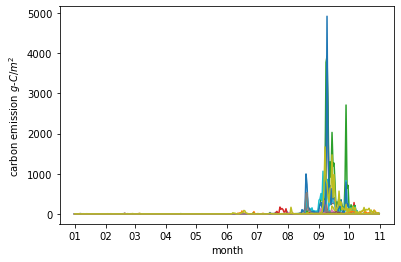

In [18]:
fig, ax = plt.subplots()
for i, y in enumerate(yy):
    for j, x in enumerate(xx):
        agg_data[i, j] = dr.loc[:, y:y-grid_step, x:x+grid_step].sum(dim=['lat', 'lon'])
        ax.plot(time_2020, agg_data[i][j], label=(i,j))
myFmt = mdates.DateFormatter('%m')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('month')
ax.set_ylabel('carbon emission $g$-$C / m^2$')
plt.show()

Find when the fire is happening

In [19]:
start_end_idx = [[None for _ in range(len(agg_data))] for _ in range(len(agg_data))]

In [20]:
for i in range(len(yy)):
    for j in range(len(xx)):
        arr = agg_data[i][j]
        diff_arr = np.diff(np.sign(arr))
        end_idx = np.where(diff_arr==-1)[0]
        start_idx = np.where(diff_arr==1)[0]+1
        if len(start_idx) != 0 and len(end_idx) != 0:
            if end_idx[0] < start_idx[0]:
                end_idx = end_idx[1:]
            if start_idx[-1] > end_idx[-1]:
                start_idx = start_idx[:-1]
            start_end_idx[i][j] = np.dstack((start_idx, end_idx)).reshape((-1, 2))

Create csv files of carbon emission on each grid and each fire events for analysis in R

In [21]:
term_limit = (datetime.datetime(2020, 11, 1) - datetime.datetime(2020, 1, 1)).days

In [22]:
for i in range(len(yy)):
    for j in range(len(xx)):
        arr = start_end_idx[i][j]
        if arr is not None:
            duration = arr[:, 1] - arr[:, 0]
            terms = arr[duration > 7]
            for term in terms:
                term_duration = term[1] - term[0]
                term_s = term[0] - term_duration
                term_s = term_s if term_s >= 0 else 0
                term_e = term[1] + term_duration
                term_e = term_e if term_e <= term_limit else term_limit
                gy1 = yy[i]
                gy2 = gy1 - grid_step
                gx1 = xx[j]
                gx2 = gx1 + grid_step
                start_date = datetime.datetime(2020, 1, 1) + datetime.timedelta(days=int(term_s))
                end_date = datetime.datetime(2020, 1, 1) + datetime.timedelta(days=int(term_e))
                daterange = np.arange(start_date, end_date, dtype='datetime64[D]')
                emission = agg_data[i, j, term_s:term_e]
                d = {'date': daterange, 
                     'x1': [gx1 for _ in range(len(emission))], 
                     'x2': [gx2 for _ in range(len(emission))], 
                     'y1': [gy1 for _ in range(len(emission))], 
                     'y2': [gy2 for _ in range(len(emission))], 
                     'emission': emission}
                pd.DataFrame(data=d).to_csv("gfed_fire_term/{x1}-{x2}_{y1}-{y2}_{term_s}-{term_e}.csv".format(x1=gx1, x2=gx2, y1=gy1, y2=gy2, term_s=term_s, term_e=term_e))

Test on one grid

In [25]:
gfed_list = glob.glob('gfed_fire_term/*')

In [26]:
df1 = pd.read_csv(gfed_list[0], index_col=[0], parse_dates=['date'])
df1.head()

,date,x1,x2,y1,y2,emission
0,2020-07-07,-122.5,-120.0,42.5,40.0,0.0
1,2020-07-08,-122.5,-120.0,42.5,40.0,0.0
2,2020-07-09,-122.5,-120.0,42.5,40.0,0.0
3,2020-07-10,-122.5,-120.0,42.5,40.0,0.0
4,2020-07-11,-122.5,-120.0,42.5,40.0,0.0


Getting PM2.5/ozone data based on the GFED grid - OpenAQ API [here](https://docs.openaq.org/).

In [29]:
get_measurement_url = "https://api.openaq.org/v1/measurements"

In [34]:
# grid and term
lon = df1.iloc[0]['x1'] + grid_step / 2
lat = df1.iloc[0]['y1'] - grid_step / 2
from_date = df1.date.min().date()
to_date = df1.date.max().date()
print(from_date, to_date)
print(str(lat) + "," + str(lon))

2020-07-07 2020-08-11
41.25,-121.25


In [35]:
measurement_param = {
    'parameter': 'pm25',
    'has_geo': True,
    'coordinates': str(lat) + "," + str(lon),
    'radius': grid_step / 2 * 111000,
    'date_from': str(from_date),
    'date_to': str(to_date),
    'limit': 10000,
    'format': 'csv'
}

In [36]:
measure_response = requests.get(get_measurement_url, params=measurement_param)

In [37]:
print(measure_response)

<Response [200]>


In [38]:
o3_df1 = pd.read_csv(io.BytesIO(measure_response.content), sep=",", parse_dates=["utc", "local"])

Ozone dataframe for the grid

In [39]:
o3_df1.head()

,location,city,country,utc,local,parameter,value,unit,latitude,longitude,attribution
0,Lakeview - Center &,LAKE,US,2020-08-11 00:00:00+00:00,2020-08-10 17:00:00-07:00,pm25,2.1,µg/m³,42.189215,-120.353969,"[{""url"":""http://www.airnow.gov/"",""name"":""US EP..."
1,Klamath Falls - Pete,Klamath Falls,US,2020-08-11 00:00:00+00:00,2020-08-10 17:00:00-07:00,pm25,2.3,µg/m³,42.190296,-121.731369,"[{""url"":""http://www.airnow.gov/"",""name"":""US EP..."
2,Chester BAM,PLUMAS,US,2020-08-11 00:00:00+00:00,2020-08-10 17:00:00-07:00,pm25,3.0,µg/m³,40.301899,-121.235001,"[{""url"":""http://www.airnow.gov/"",""name"":""US EP..."
3,Redding,Redding,US,2020-08-11 00:00:00+00:00,2020-08-10 17:00:00-07:00,pm25,8.0,µg/m³,40.549700,-122.379200,"[{""url"":""http://www.airnow.gov/"",""name"":""US EP..."
4,Yreka,SISKIYOU,US,2020-08-11 00:00:00+00:00,2020-08-10 17:00:00-07:00,pm25,9.0,µg/m³,41.726790,-122.633590,"[{""url"":""http://www.airnow.gov/"",""name"":""US EP..."


Take daily average over locations (like `tapply` in R)

In [40]:
mean_df1 = o3_df1.groupby([pd.Grouper(key="utc", freq="D")]).agg({'value': lambda x: x.mean(skipna=True)})
mean_df1.head()

,value
utc,
2020-07-07 00:00:00+00:00,4.008197
2020-07-08 00:00:00+00:00,4.141481
2020-07-09 00:00:00+00:00,4.630233
2020-07-10 00:00:00+00:00,4.502899
2020-07-11 00:00:00+00:00,4.447664


Plot carbon emission and PM2.5 concentration in the grid during the fire event

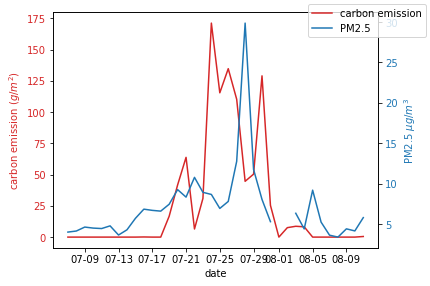

In [41]:
datefmt = mdates.DateFormatter('%m-%d')

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('carbon emission ($g/m^2$)', color=color)
ax1.plot(df1.date, df1.emission, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_formatter(datefmt)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('PM2.5 $\mu g/m^3$', color=color)  # we already handled the x-label with ax1
ax2.plot(mean_df1.value, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_formatter(datefmt)

fig.legend(["carbon emission", "PM2.5"])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Production of dataset for each grid

Create PM2.5 dataset for each grid, plot with GFED carbon emission

parameters: 42.5 -122.5 2020-07-07 2020-08-11
<Response [200]>
3626


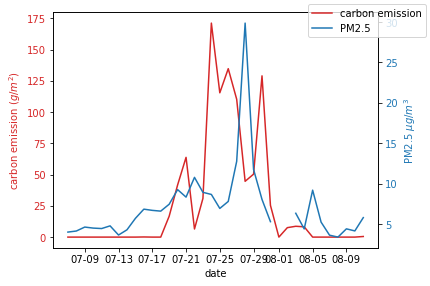

parameters: 40.0 -122.5 2020-06-23 2020-10-31
<Response [200]>
10000
<Response [200]>
10000


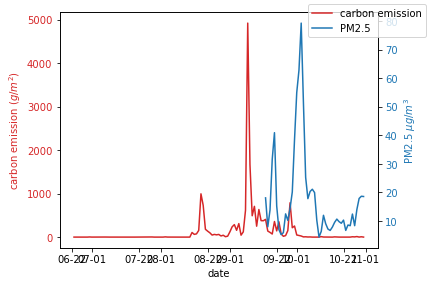

parameters: 37.5 -122.5 2020-07-09 2020-10-27
<Response [200]>
10000
<Response [200]>
10000


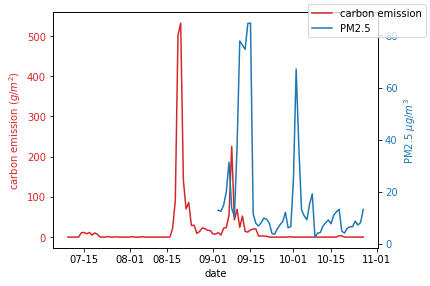

parameters: 47.5 -117.5 2020-08-15 2020-10-04
<Response [200]>
10000
<Response [200]>
6290


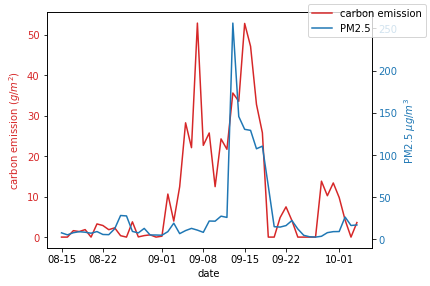

parameters: 40.0 -122.5 2020-01-22 2020-03-18
<Response [200]>
10000
<Response [200]>
10000


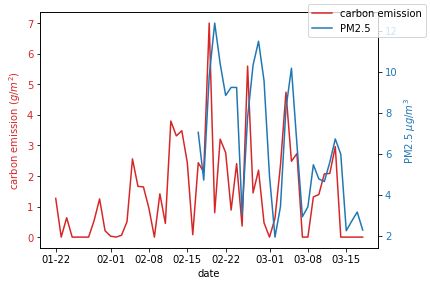

parameters: 35.0 -117.5 2020-08-22 2020-10-02
<Response [200]>
10000
<Response [200]>
3377


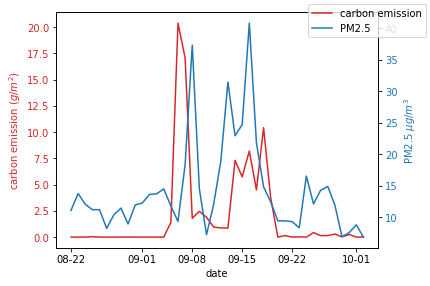

parameters: 47.5 -115.0 2020-08-31 2020-09-26
<Response [200]>
2851


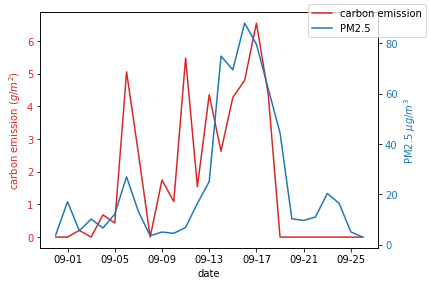

parameters: 35.0 -117.5 2020-07-20 2020-08-15
<Response [200]>
5844


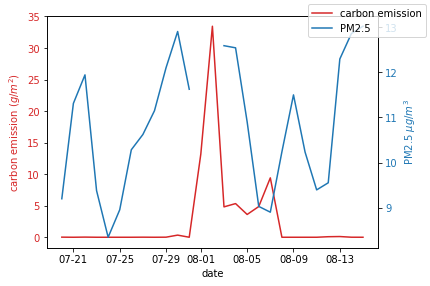

parameters: 47.5 -122.5 2020-08-12 2020-09-16
<Response [200]>
10000
<Response [200]>
1757


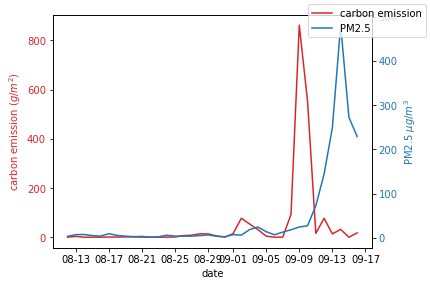

parameters: 40.0 -125.0 2020-06-24 2020-10-31
<Response [200]>
9984


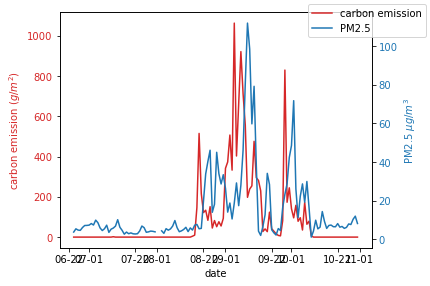

parameters: 40.0 -120.0 2020-10-01 2020-10-30
<Response [200]>
6783


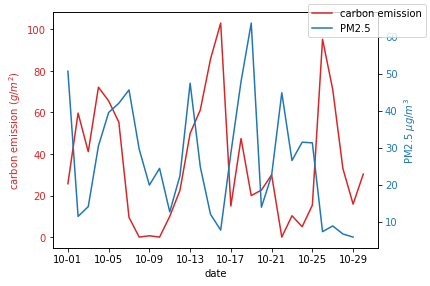

parameters: 45.0 -112.5 2020-09-16 2020-10-21
<Response [200]>
3617


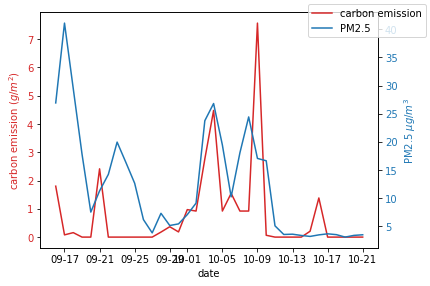

parameters: 45.0 -125.0 2020-08-29 2020-09-27
<Response [200]>
8220


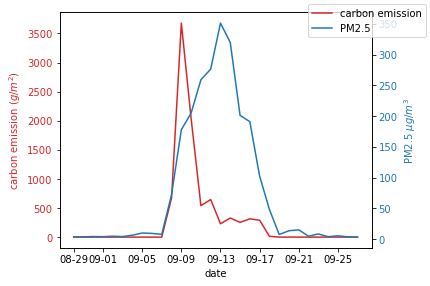

parameters: 42.5 -125.0 2020-06-28 2020-10-31
<Response [200]>
10000
<Response [200]>
29


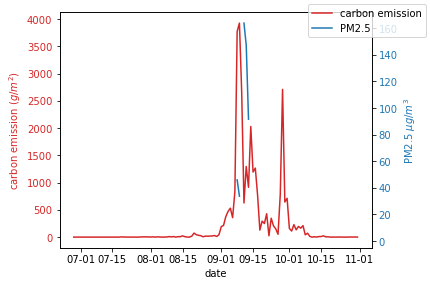

parameters: 50.0 -117.5 2020-08-26 2020-09-21
<Response [200]>
4352


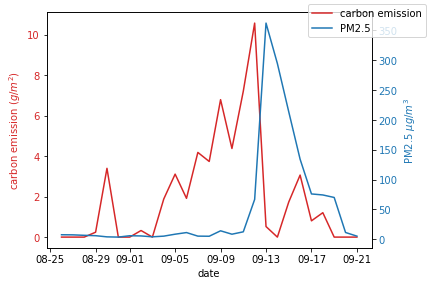

parameters: 37.5 -120.0 2020-02-07 2020-03-31
<Response [200]>
10000
<Response [200]>
4735


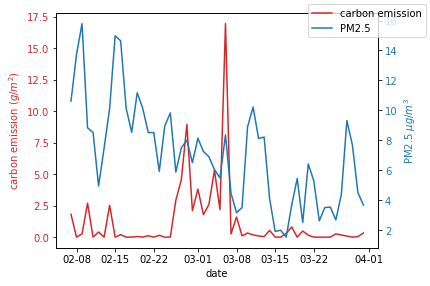

parameters: 45.0 -122.5 2020-07-13 2020-10-25
<Response [200]>
10000
<Response [200]>
9229


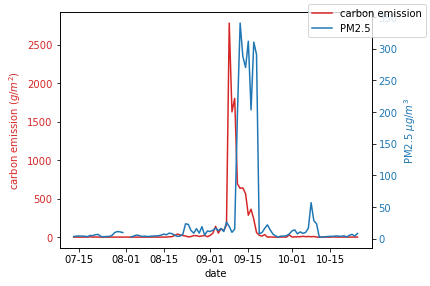

parameters: 50.0 -120.0 2020-08-24 2020-09-22
<Response [200]>
4285


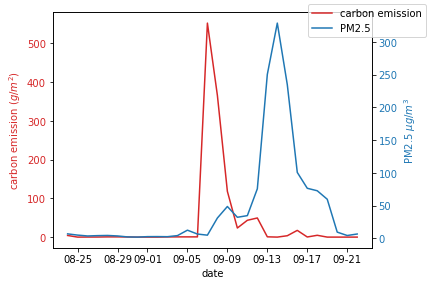

parameters: 35.0 -112.5 2020-05-29 2020-07-15
<Response [200]>
10000
<Response [200]>
950


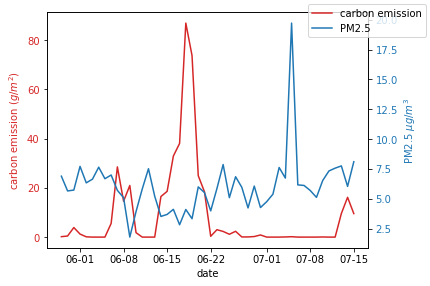

parameters: 35.0 -120.0 2020-08-09 2020-10-31
<Response [200]>
10000
<Response [200]>
10000


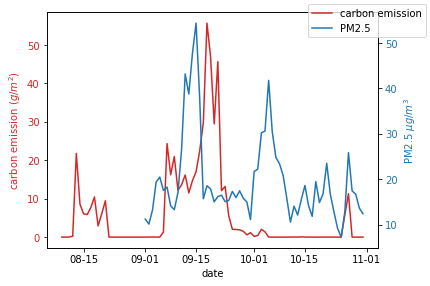

parameters: 40.0 -120.0 2020-09-01 2020-10-24
<Response [200]>
10000
<Response [200]>
0


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [43]:
for gfed_path in gfed_list:
    gfed_df = pd.read_csv(gfed_path, index_col=[0], parse_dates=['date'])
    lon = gfed_df.iloc[0]['x1'] + grid_step / 2
    lat = gfed_df.iloc[0]['y1'] - grid_step / 2
    from_date = gfed_df.date.min().date()
    to_date = gfed_df.date.max().date()
    print("parameters:", gfed_df.iloc[0]['y1'], gfed_df.iloc[0]['x1'], from_date, to_date)
    measurement_param = {
        'parameter': 'pm25',
        'has_geo': True,
        'coordinates': str(lat) + "," + str(lon),
        'radius': grid_step / 2 * 111000,
        'date_from': str(from_date),
        'date_to': str(to_date),
        'limit': 10000,
        'format': 'csv'
    }
    measure_response = requests.get(get_measurement_url, params=measurement_param)
    print(measure_response)
    pm_df = pd.read_csv(io.BytesIO(measure_response.content), sep=",", parse_dates=["utc", "local"])
    print(len(pm_df))
    if pm_df.empty:
        continue
    elif len(pm_df) == 10000:
        measurement_param = {
            'parameter': 'pm25',
            'has_geo': True,
            'coordinates': str(lat) + "," + str(lon),
            'radius': grid_step / 2 * 55000,
            'date_from': str(from_date),
            'date_to': str(to_date),
            'limit': 10000,
            'format': 'csv'
        }
        measure_response = requests.get(get_measurement_url, params=measurement_param)
        print(measure_response)
        pm_df = pd.read_csv(io.BytesIO(measure_response.content), sep=",", parse_dates=["utc", "local"])
        print(len(pm_df))
    mean_df = pm_df.groupby([pd.Grouper(key="utc", freq="D")]).agg({'value': lambda x: x.mean(skipna=True)})
    mean_df.to_csv("openAQ_term_pm25/{filename}".format(filename=path.basename(gfed_path)))

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('date')
    ax1.set_ylabel('carbon emission ($g/m^2$)', color=color)
    ax1.plot(gfed_df.date, gfed_df.emission, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.xaxis.set_major_formatter(datefmt)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('PM2.5 $\mu g/m^3$', color=color)  # we already handled the x-label with ax1
    ax2.plot(mean_df.value, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.xaxis.set_major_formatter(datefmt)

    fig.legend(["carbon emission", "PM2.5"])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

Same for ozone

parameters: 42.5 -122.5 2020-07-07 2020-08-11
<Response [200]>
3587


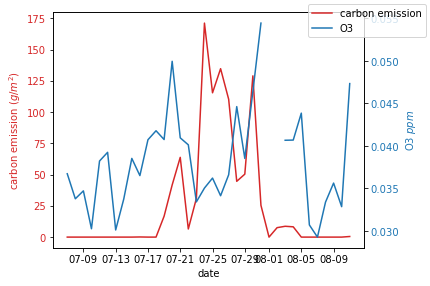

parameters: 40.0 -122.5 2020-06-23 2020-10-31
<Response [200]>
10000
<Response [200]>
10000


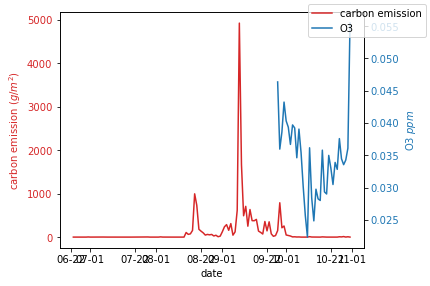

parameters: 37.5 -122.5 2020-07-09 2020-10-27
<Response [200]>
10000
<Response [200]>
7656


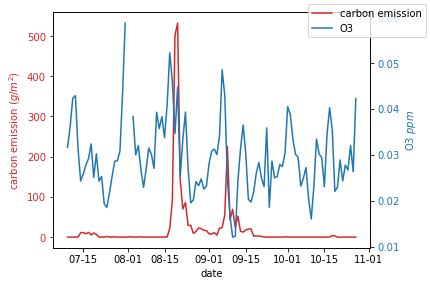

parameters: 47.5 -117.5 2020-08-15 2020-10-04
<Response [200]>
717


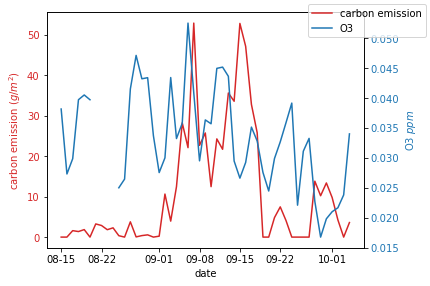

parameters: 40.0 -122.5 2020-01-22 2020-03-18
<Response [200]>
10000
<Response [200]>
10000


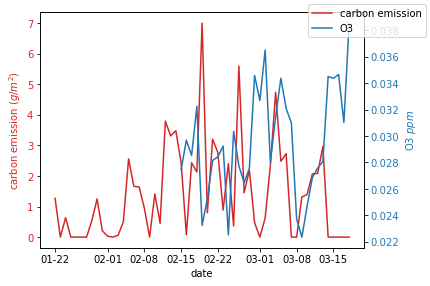

parameters: 35.0 -117.5 2020-08-22 2020-10-02
<Response [200]>
10000
<Response [200]>
5100


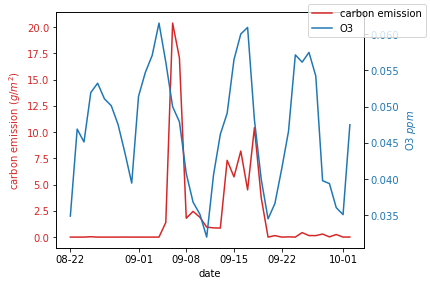

parameters: 47.5 -115.0 2020-08-31 2020-09-26
<Response [200]>
481


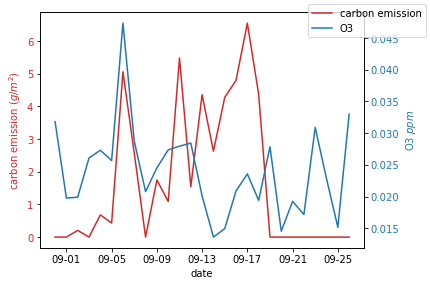

parameters: 35.0 -117.5 2020-07-20 2020-08-15
<Response [200]>
10000
<Response [200]>
2544


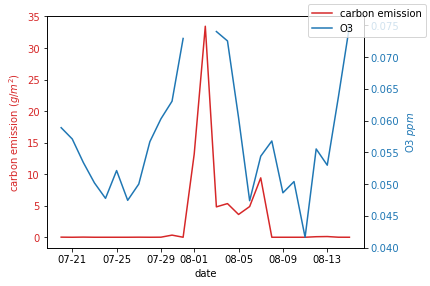

parameters: 47.5 -122.5 2020-08-12 2020-09-16
<Response [200]>
3868


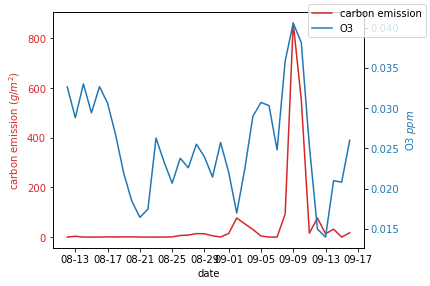

parameters: 40.0 -125.0 2020-06-24 2020-10-31
<Response [200]>
7141


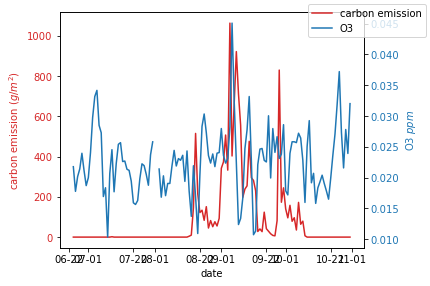

parameters: 40.0 -120.0 2020-10-01 2020-10-30
<Response [200]>
6347


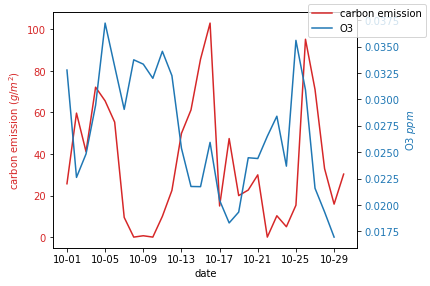

parameters: 45.0 -112.5 2020-09-16 2020-10-21
<Response [200]>
1559


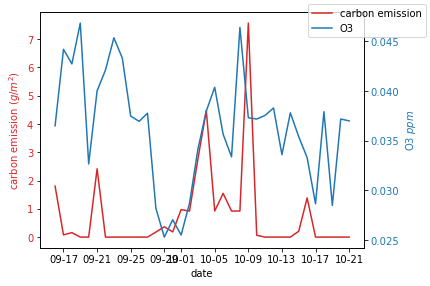

parameters: 45.0 -125.0 2020-08-29 2020-09-27
<Response [200]>
1646


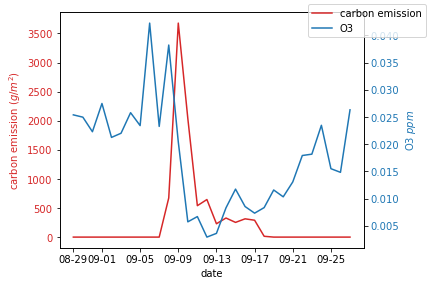

parameters: 42.5 -125.0 2020-06-28 2020-10-31
<Response [200]>
8569


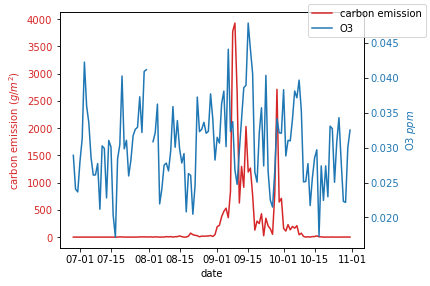

parameters: 50.0 -117.5 2020-08-26 2020-09-21
<Response [200]>
407


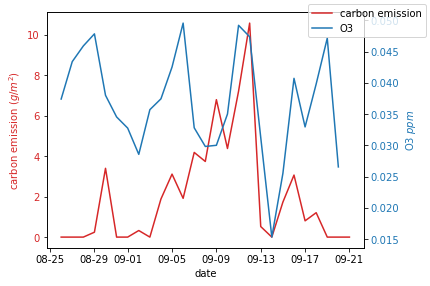

parameters: 37.5 -120.0 2020-02-07 2020-03-31
<Response [200]>
10000
<Response [200]>
7219


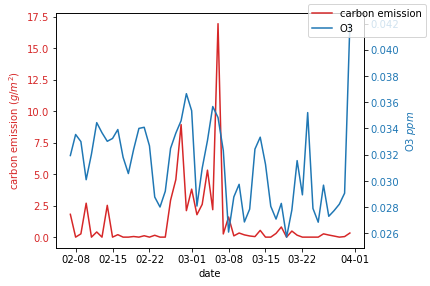

parameters: 45.0 -122.5 2020-07-13 2020-10-25
<Response [200]>
0
parameters: 50.0 -120.0 2020-08-24 2020-09-22
<Response [200]>
587


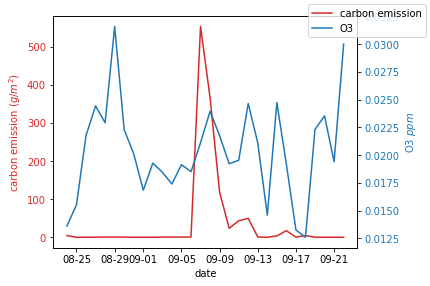

parameters: 35.0 -112.5 2020-05-29 2020-07-15
<Response [200]>
10000
<Response [200]>
10000


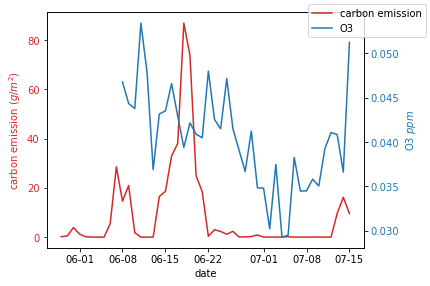

parameters: 35.0 -120.0 2020-08-09 2020-10-31
<Response [200]>
10000
<Response [200]>
10000


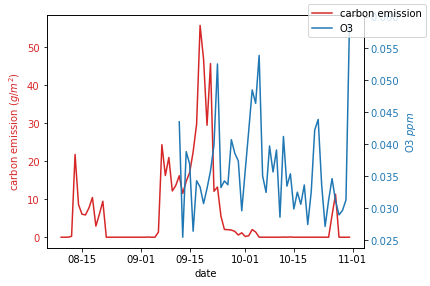

parameters: 40.0 -120.0 2020-09-01 2020-10-24
<Response [200]>
10000
<Response [200]>
0


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [45]:
for gfed_path in gfed_list:
    gfed_df = pd.read_csv(gfed_path, index_col=[0], parse_dates=['date'])
    lon = gfed_df.iloc[0]['x1'] + grid_step / 2
    lat = gfed_df.iloc[0]['y1'] - grid_step / 2
    from_date = gfed_df.date.min().date()
    to_date = gfed_df.date.max().date()
    print("parameters:", gfed_df.iloc[0]['y1'], gfed_df.iloc[0]['x1'], from_date, to_date)
    measurement_param = {
        'parameter': 'o3',
        'has_geo': True,
        'coordinates': str(lat) + "," + str(lon),
        'radius': grid_step / 2 * 111000,
        'date_from': str(from_date),
        'date_to': str(to_date),
        'limit': 10000,
        'format': 'csv'
    }
    measure_response = requests.get(get_measurement_url, params=measurement_param)
    print(measure_response)
    pm_df = pd.read_csv(io.BytesIO(measure_response.content), sep=",", parse_dates=["utc", "local"])
    print(len(pm_df))
    if pm_df.empty:
        continue
    elif len(pm_df) == 10000:
        measurement_param = {
            'parameter': 'o3',
            'has_geo': True,
            'coordinates': str(lat) + "," + str(lon),
            'radius': grid_step / 2 * 55000,
            'date_from': str(from_date),
            'date_to': str(to_date),
            'limit': 10000,
            'format': 'csv'
        }
        measure_response = requests.get(get_measurement_url, params=measurement_param)
        print(measure_response)
        pm_df = pd.read_csv(io.BytesIO(measure_response.content), sep=",", parse_dates=["utc", "local"])
        print(len(pm_df))
    mean_df = pm_df.groupby([pd.Grouper(key="utc", freq="D")]).agg({'value': lambda x: x.mean(skipna=True)})
    mean_df.to_csv("openAQ_term_pm25/{filename}".format(filename=path.basename(gfed_path)))

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('date')
    ax1.set_ylabel('carbon emission ($g/m^2$)', color=color)
    ax1.plot(gfed_df.date, gfed_df.emission, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.xaxis.set_major_formatter(datefmt)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('O3 $ppm$', color=color)  # we already handled the x-label with ax1
    ax2.plot(mean_df.value, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.xaxis.set_major_formatter(datefmt)

    fig.legend(["carbon emission", "O3"])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

Construct dataset for carbon emission in California and ozone in Denver for August fire events

In [46]:
time_august = np.arange('2020-08-01', '2020-09-01', dtype='datetime64[D]')
august_data = np.empty((len(yy), len(xx), len(time_august)))

Carbon emission aggregation

In [47]:
for i, y in enumerate(yy):
    for j, x in enumerate(xx):
        august_data[i, j] = dr.loc[time_august, y:y-grid_step, x:x+grid_step].sum(dim=['lat', 'lon'])

Save csv for carbon emission in each grid

In [71]:
for i in range(len(yy)):
    for j in range(len(xx)):
        gy1 = yy[i]
        gy2 = gy1 - grid_step
        gx1 = xx[j]
        gx2 = gx1 + grid_step
        emission = august_data[i, j, :]
        d = {'date': time_august, 
             'x1': [gx1 for _ in range(len(emission))], 
             'x2': [gx2 for _ in range(len(emission))], 
             'y1': [gy1 for _ in range(len(emission))], 
             'y2': [gy2 for _ in range(len(emission))], 
             'emission': emission}
        pd.DataFrame(data=d).to_csv("gfed_august/{x1}-{x2}_{y1}-{y2}.csv".format(x1=gx1, x2=gx2, y1=gy1, y2=gy2))

Ozone dataset for Denver

In [52]:
measurement_param = {
        'parameter': 'o3',
        'has_geo': True,
        'city': 'Denver-Aurora',
        'date_from': '2020-08-01',
        'date_to': '2020-08-31',
        'limit': 10000,
        'format': 'csv'
}
measure_response = requests.get(get_measurement_url, params=measurement_param)
print(measure_response)

<Response [200]>


In [53]:
o3_denver_df = pd.read_csv(io.BytesIO(measure_response.content), sep=",", parse_dates=["utc", "local"])

Get daily mean for the city

In [54]:
mean_df = o3_denver_df.groupby([pd.Grouper(key="utc", freq="D")]).agg({'value': lambda x: x.mean(skipna=True)})
mean_df.to_csv("denver_o3.csv")